# Import

In [20]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import Compose, ToPILImage, Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from IPython.display import display

# gpu 사용 가능 여부
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data load

In [21]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
display(train.head())
display(test.head())

,ID,label,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,TRAIN_000,building,251,196,51,63,68,78,189,34,...,85,195,63,30,73,65,63,201,251,248
1,TRAIN_001,building,247,184,203,237,255,255,193,255,...,242,239,241,242,242,241,241,241,240,238
2,TRAIN_002,building,217,223,232,231,239,212,109,115,...,96,90,103,166,191,163,190,190,206,231
3,TRAIN_003,cat,133,149,153,138,68,157,159,166,...,245,241,247,255,250,190,186,244,254,201
4,TRAIN_004,building,240,213,187,159,112,134,239,233,...,148,59,163,133,92,196,221,194,182,251


,ID,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,TEST_000,186,189,189,190,190,190,192,191,192,...,200,200,199,197,197,194,193,191,192,193
1,TEST_001,209,219,227,227,220,218,225,225,225,...,61,103,134,143,236,220,219,219,219,214
2,TEST_002,52,232,249,209,117,63,50,70,23,...,115,112,148,173,50,20,212,251,246,249
3,TEST_003,239,230,204,222,194,198,228,235,198,...,202,170,165,178,145,175,234,197,226,238
4,TEST_004,247,247,248,247,246,246,245,246,245,...,148,133,212,243,230,232,233,234,234,234


# Image check

In [22]:
# 랜덤으로 5개의 이미지 추출
random_index = np.random.choice(len(train), 5, replace=False)
print('추출된 이미지 index',random_index)
samples = train.iloc[random_index]
samples

추출된 이미지 index [119 465  26  78 260]


,ID,label,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
119,TRAIN_119,cat,229,231,233,222,227,224,219,234,...,241,243,242,240,239,239,239,239,240,243
465,TRAIN_465,truck,247,247,247,248,247,248,248,248,...,231,249,247,247,247,248,248,248,248,248
26,TRAIN_026,truck,235,203,243,238,238,235,239,203,...,189,232,241,237,238,239,240,241,241,242
78,TRAIN_078,airplane,210,192,193,192,192,191,191,191,...,151,139,126,117,114,114,116,121,130,132
260,TRAIN_260,building,118,167,200,185,155,173,201,233,...,211,206,217,200,166,159,158,251,153,88


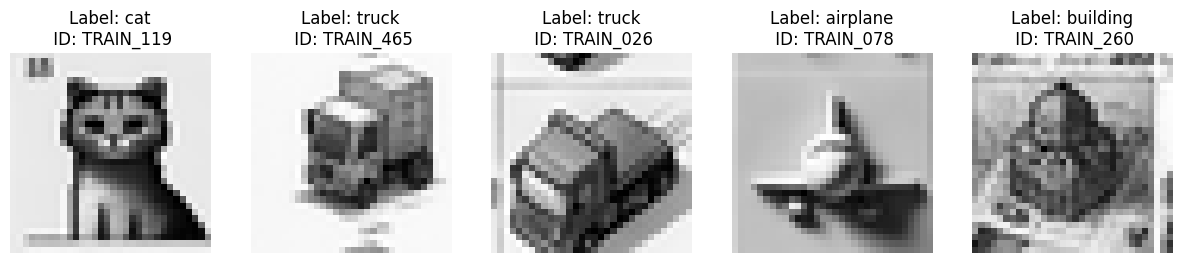

In [23]:
# 이미지 시각화
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, (idx, sample) in enumerate(samples.iterrows()):
    image_data = sample.iloc[2:].values.astype(np.uint8).reshape(32, 32)  # 32x32 변환 (=1024)
    axes[i].imshow(image_data, cmap='gray')
    axes[i].set_title(f"Label: {sample['label']}\n ID: {sample['ID']}")
    axes[i].axis("off")

In [24]:
# 데이터 준비
X = train.iloc[:,2:].values     # 32x32 (1024 픽셀)

# 라벨 인코더 (라벨 -> 숫자)
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(train["label"])

In [25]:
# 테스트 데이터
test_data = test.iloc[:, 1:].values
test_data

array([[186, 189, 189, ..., 191, 192, 193],
       [209, 219, 227, ..., 219, 219, 214],
       [ 52, 232, 249, ..., 251, 246, 249],
       ...,
       [238, 239, 244, ...,  93,  60, 120],
       [107, 116, 118, ..., 107, 106, 108],
       [168, 169, 171, ..., 164,  93, 100]], shape=(250, 1024))

In [26]:
# 8:2로 train, valid 분리
# valid_idx = np.random.choice(len(train), round(len(train) * 0.2), replace=False)
# train_idx = train.index.difference(valid_idx)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


for train_idx, valid_idx in skf.split(train.iloc[:, 2:], train['label']):
    break

print(train_idx, valid_idx)

[  0   3   4   6   7   8  12  13  14  15  18  19  20  22  23  24  25  26
  27  29  30  31  33  34  35  37  38  39  40  43  44  45  47  49  51  52
  53  54  56  57  58  59  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  78  79  80  81  82  84  85  88  89  90  91  93  95  96
  97 100 101 102 104 106 107 108 109 110 111 112 114 115 116 117 119 120
 121 122 123 124 125 127 128 129 130 131 132 133 135 136 137 139 140 141
 142 144 145 146 150 151 152 153 154 156 157 158 160 162 163 164 165 166
 167 169 170 171 172 174 175 177 178 179 180 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 197 198 199 201 202 203 205 206 207 209 210
 211 212 213 214 215 216 217 218 220 221 222 224 225 227 228 229 230 231
 232 233 234 235 236 237 238 239 241 242 243 244 245 246 248 252 253 254
 257 258 259 260 261 262 263 264 265 267 268 271 273 274 275 276 277 280
 281 282 283 284 285 286 287 288 290 291 292 293 294 295 296 297 298 299
 300 301 302 303 304 305 306 307 308 309 310 311 31

In [27]:
class CustomDataset():
    def __init__(self,image_df = None, label_df = None, mode = "train", transform = None):
        self.image_df = image_df.reset_index(drop=True)
        # self.label_df = label_df
        self.label_df = label_df.reset_index(drop=True) if label_df is not None else None
        self.transform = transform

    
    def __getitem__(self, idx):
        # Reshape to (32, 32) from flattened data
        image = self.image_df.iloc[idx].values.astype(np.uint8).reshape(32, 32)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # shape: (1, 32, 32)

        if self.transform:
            image = self.transform(image)

        if self.label_df is not None:
            label = torch.tensor(self.label_df.iloc[idx], dtype=torch.long)
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.image_df)

In [28]:
train_transform = Compose([
    ToPILImage(),
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5]),
])

In [29]:
train_dataset = CustomDataset(image_df=train.iloc[train_idx, 2:], label_df=train.iloc[train_idx, 1], transform=train_transform)
valid_dataset = CustomDataset(image_df=train.iloc[valid_idx, 2:], label_df=train.iloc[valid_idx, 1], transform=train_transform)
test_dataset = CustomDataset(image_df=test.iloc[:, 1:], transform=train_transform)

In [30]:
loader_params = {
    'batch_size': 5,
    'num_workers': 8,
    'pin_memory': True
}

train_loader = DataLoader(train_dataset, shuffle=True, **loader_params)
valid_loader = DataLoader(valid_dataset, shuffle=False, **loader_params)
test_loader = DataLoader(test_dataset, shuffle=False, **loader_params)